<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/8_4_Multi_Branch_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.4 : Multi-Branch Networks (GoogLeNet)

In [ ]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [10]:
a1 = torch.randn(1, 64, 28, 28)
a2 = torch.randn(1, 128, 28, 28)
a3 = torch.randn(1, 32, 28, 28)
a4 = torch.randn(1, 32, 28, 28)

a = torch.cat((a1, a2, a3, a4), dim=1)
print(a.shape)

c = 0.0
for a in list((a1, a2, a3, a4)):
  c += a.shape[1]
print(c)

torch.Size([1, 256, 28, 28])
256.0


In [5]:
class Inception(nn.Module):

  def __init__(self, c1, c2, c3, c4, **kwargs):
    '''
    c1 to c4 are the number of output channels for each branch
    '''

    super().__init__(**kwargs)

    # branch-1 : 
    self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)

    # branch-2 : 
    self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
    self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)

    # branch-3 :
    self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
    self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)

    # branch-4 :
    self.b4_1 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
    self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

  def forward(self, X):
    b1 = F.relu(self.b1_1(X))
    b2 = F.relu(self.b2_2(F.relu(self.b2_1(X))))
    b3 = F.relu(self.b3_2(F.relu(self.b3_1(X))))
    b4 = F.relu(self.b4_2(self.b4_1(X)))
    
    return torch.cat((b1, b2, b3, b4), dim=1)

In [6]:
d2l.init_cnn

In [7]:
a = nn.LazyLinear(20)
a.apply??

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
class GoogleNet(d2l.Classifier):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        self.b1(), 
        self.b2(),
        self.b3(),
        self.b4(),
        self.b5(),
        nn.LazyLinear(num_classes)
    )
    self.net.apply(d2l.init_cnn)

  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b3(self):
    return nn.Sequential(
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b4(self):
    return nn.Sequential(
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b5(self):
    return nn.Sequential(
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
    )

In [12]:
from torchsummary import summary
summary(GoogleNet(), (1, 96, 96), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
              ReLU-2           [-1, 64, 48, 48]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]           4,160
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 192, 24, 24]         110,784
              ReLU-7          [-1, 192, 24, 24]               0
         MaxPool2d-8          [-1, 192, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          12,352
           Conv2d-10           [-1, 96, 12, 12]          18,528
           Conv2d-11          [-1, 128, 12, 12]         110,720
           Conv2d-12           [-1, 16, 12, 12]           3,088
           Conv2d-13           [-1, 32, 12, 12]          12,832
        MaxPool2d-14          [-1, 192,

just took 8 min to complete training

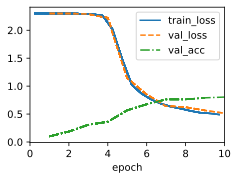

In [7]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Ex 8.4:

Using 5x5, 7x7 convs in the Inception Block

In [10]:
#@title Inception1
class Inception1(nn.Module):

  def __init__(self, c1, c2, c3, c4, **kwargs):
    super().__init__(**kwargs)
    self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)

    self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
    self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=5, padding=2)
    
    self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
    self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=7, padding=3)

    self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

  def forward(self, X):
    b1 = F.relu(self.b1_1(X))
    b2 = F.relu(self.b2_2(F.relu(self.b2_1(X))))
    b3 = F.relu(self.b3_2(F.relu(self.b3_1(X))))
    b4 = F.relu(self.b4_2(self.b4_1(X)))

    return torch.cat((b1, b2, b3, b4), dim=1)

In [11]:
#@title GoogleNet1
class GoogleNet1(d2l.Classifier):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        self.b1(), 
        self.b2(),
        self.b3(),
        self.b4(),
        self.b5(),
        nn.LazyLinear(num_classes)
    )
    self.net.apply(d2l.init_cnn)

  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b3(self):
    return nn.Sequential(
        Inception1(64, (96, 128), (16, 32), 32),
        Inception1(128, (128, 192), (32, 96), 64),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b4(self):
    return nn.Sequential(
        Inception1(192, (96, 208), (16, 48), 64),
        Inception1(160, (112, 224), (24, 64), 64),
        Inception1(128, (128, 256), (24, 64), 64),
        Inception1(112, (144, 288), (32, 64), 64),
        Inception1(256, (160, 320), (32, 128), 128),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def b5(self):
    return nn.Sequential(
        Inception1(256, (160, 320), (32, 128), 128),
        Inception1(384, (192, 384), (48, 128), 128),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
    )

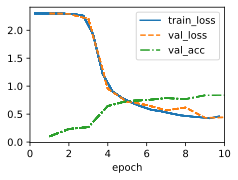

In [12]:
model = GoogleNet1(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

let's try with size = (48, 48)

In [13]:
from torchsummary import summary
summary(GoogleNet1(), (1, 48, 48), device='cpu')

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           3,200
              ReLU-2           [-1, 64, 24, 24]               0
         MaxPool2d-3           [-1, 64, 12, 12]               0
            Conv2d-4           [-1, 64, 12, 12]           4,160
              ReLU-5           [-1, 64, 12, 12]               0
            Conv2d-6          [-1, 192, 12, 12]         110,784
              ReLU-7          [-1, 192, 12, 12]               0
         MaxPool2d-8            [-1, 192, 6, 6]               0
            Conv2d-9             [-1, 64, 6, 6]          12,352
           Conv2d-10             [-1, 96, 6, 6]          18,528
           Conv2d-11            [-1, 128, 6, 6]         307,328
           Conv2d-12             [-1, 16, 6, 6]           3,088
           Conv2d-13             [-1, 32, 6, 6]          25,120
        MaxPool2d-14            [-1, 19

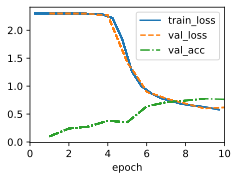

In [14]:
model = GoogleNet1(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(48, 48))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

let's try 28 x 28 images

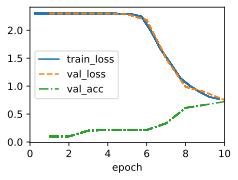

In [15]:
model = GoogleNet1(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)